# Imports and Global Variables

In [27]:
import numpy as np
import pandas as pd 
import fastf1 as f
import fastf1.plotting as p
from matplotlib import rcParams, pyplot as plt
import seaborn as sns 
import import_ipynb
from math import ceil

In [28]:
from data_transformation import compound_selection_2021, compound_selection_2022, num_rounds_2021, num_rounds_2022

In [29]:
slick_tyre_names = ["SOFT", "MEDIUM", "HARD"]

relative_compound_palette = {"SOFT":"#da291c", "MEDIUM":"#fed12e", "HARD":"#eeeeea", "INTERMEDIATE":"#43b02a", "WET":"#0166ac", "UNKNOWN":"#40e040"}
relative_compound_markers = {"SOFT":'o', "MEDIUM":'^', "HARD":'s', "INTERMEDIATE":'P', "WET":'X', "UNKNOWN":'.'}
relative_compound_labels = ["SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"]

# The absolute_compound_palette uses the 2018 colors in order of ultrasoft to hard
absolute_compound_palette = {'C1':"#00a2f3", 'C2': "#eeeeea", 'C3': "#fed12e", 'C4':"#da291c", 'C5':"#b24ba7", "INTERMEDIATE":"#43b02a", "WET":"#0166ac"}
absolute_compound_markers = {'C1':"P", "C2":'s', "C3":'^', "C4":'o', "C5":'D', "INTERMEDIATE":'P', "WET":'X', "UNKNOWN":'.'}
absolute_compound_labels = ["C1", "C2", "C3", "C4", "C5", "INTERMEDIATE", "WET"]

FreshTyre_markers = {True:'o', False:'X'}

In [30]:
# plotting setup
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.style.use("dark_background")

# Load Dataframes 

In [31]:
df_laps_2021 = pd.read_csv("transformed_laps_2021.csv", header=0, index_col=0, parse_dates=["LapStartDate"], infer_datetime_format=True, true_values=["True"], false_values=["False"])
df_laps_2022 = pd.read_csv("transformed_laps_2022.csv", header=0, index_col=0, parse_dates=["LapStartDate"], infer_datetime_format=True, true_values=["True"], false_values=["False"])

/tmp/ipykernel_526/3842765064.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_laps_2022 = pd.read_csv("transformed_laps_2022.csv", header=0, index_col=0, parse_dates=["LapStartDate"], infer_datetime_format=True, true_values=["True"], false_values=["False"])


In [32]:
# convert timedelta columns to the correct datatype
df_laps_2021[["Time", "LapTime", "PitInTime", "PitOutTime", "Sector1Time", "Sector2Time", "Sector3Time", "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", "LapStartTime", "DeltaToRep", "DeltaToFastest", "DeltaToLapRep"]] = df_laps_2021[["Time", "LapTime", "PitInTime", "PitOutTime", "Sector1Time", "Sector2Time", "Sector3Time", "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", "LapStartTime", "DeltaToRep", "DeltaToFastest", "DeltaToLapRep"]].apply(pd.to_timedelta)
df_laps_2022[["Time", "LapTime", "PitInTime", "PitOutTime", "Sector1Time", "Sector2Time", "Sector3Time", "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", "LapStartTime", "DeltaToRep", "DeltaToFastest", "DeltaToLapRep"]] = df_laps_2022[["Time", "LapTime", "PitInTime", "PitOutTime", "Sector1Time", "Sector2Time", "Sector3Time", "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", "LapStartTime", "DeltaToRep", "DeltaToFastest", "DeltaToLapRep"]].apply(pd.to_timedelta)

# track status column makes more sensse as a string
df_laps_2021["TrackStatus"] = df_laps_2021["TrackStatus"].apply(str)
df_laps_2022["TrackStatus"] = df_laps_2022["TrackStatus"].apply(str)

# Visualization Functions

## Tyre Usage

In [33]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

In [34]:
def tyre_usage_pie(year, title=None, events=None, drivers=None, slick_only=True, absolute_compound=False):
    
    """
    Make tyre usage pie chart that allows filtering by events, drivers, and slick vs wet tyres
    
    Args:
        year: int {2021, 2022}
            Championship year
        
        title: str, default:None
            
        events: list, default: None
            A list containing the round number (as int) or the names of events
            e.g. [1, "Hungary", "British Grand Prix", "Monza"]
            Name fuzzy matching provided by fastf1.get_event()
            Using the default value will select all events
            
        drivers: list, default:None
            A list containing three-letter driver abbreviations 
            e.g. ["VER", "HAM"]
            Using the default value will select all drivers
            
        slick_only: bool, default:True
            If true, only laps raced on slick tyres are counted
            If false, all laps (with known tyre compound) are counted
            
        absolute_compound: bool, default:False
            If true, group tyres by their absolute compound names (C1, C2 etc.)
            If false, group tyres by their names in the respective events (SOFT, MEDIUM, HARD)
          
    Returns: Figure object
    """    
    included_laps = pd.DataFrame()
    
    if year == 2021:
        included_laps = df_laps_2021
    elif year == 2022:
        included_laps = df_laps_2022
    else:
        raise ValueError("Year requested ({}) not available".format(year))
    
    if events is None:
        events = pd.unique(included_laps["RoundNumber"])
    else:
        events = [f.get_event(year, event)["RoundNumber"] if isinstance(event, str) else event for event in events]
        
    if drivers is None:
        drivers = pd.unique(included_laps["DriverNumber"])

    if slick_only:
        included_laps = included_laps[included_laps["IsSlick"] == True]  

    included_laps = included_laps[(included_laps["RoundNumber"].isin(events)) & (included_laps["DriverNumber"].isin(drivers))]
    
    
    fig, ax = plt.subplots(figsize=(10,6))
    plt.style.use("default")
    
    if absolute_compound:
        lap_counts = included_laps.groupby("CompoundName").count()
        labels = lap_counts.index
        palette = [absolute_compound_palette[label] for label in labels]

        # Driver column is used because it is not nullable and therefore holds the correct count
        counts = [lap_counts.loc[i]["Driver"] for i in labels]
        
        wedges, texts, autotexts = ax.pie(x=counts, 
                                          labels=labels, 
                                          colors=palette, 
                                          autopct=make_autopct(counts), 
                                          counterclock=False, 
                                          startangle=90)
    else:
        lap_counts = included_laps.groupby("Compound").count()
        labels = lap_counts.index
        counts = [lap_counts.loc[i]["Driver"] for i in lap_counts.index]
        palette = [relative_compound_palette[label] for label in labels]

        wedges, texts, autotexts = ax.pie(x=counts, 
                                          labels=labels, 
                                          colors=palette, 
                                          autopct=make_autopct(counts), 
                                          counterclock=False, 
                                          startangle=90)

    ax.legend(labels=labels, title="Compound Names", loc="best")
    ax.axis("equal")
    ax.set_title(title)
    plt.setp(autotexts, size=12)
    plt.show()
    
    return fig

## Lap Time Scatterplot

### Lap Times by Event and Drivers

In [35]:
def lap_filter_round_driver(row, round_number, drivers):
    """
    Filter by round number and drivers    
    """
    
    return row.loc["RoundNumber"] == round_number and row.loc["Driver"] in drivers 

In [36]:
def lap_filter_upper_accurate(row, upper_bound):
    """
    Filter by IsAccurate and upper bound
    """
    
    if upper_bound is None:
        upper_bound = 50
    
    return row.loc["PctFromFastest"] < upper_bound and row.loc["IsAccurate"]

In [37]:
def plot_args(absolute_compound):
    """
    Given the input argument, return a list of the corresponding arguments to be supplied to the plotting function
    
    Args:
        absolute_compound: bool
            If true, use absolute compound names (C1, C2 ...) in legend
            Else, use relative compound names (SOFT, MEDIUM, HARD) in legend
    
    Returns: tuple
        (hue, palette, marker, labels)
    """    
    if absolute_compound:
        return ("CompoundName", absolute_compound_palette, absolute_compound_markers, absolute_compound_labels)
    else:
        return ("Compound", relative_compound_palette, relative_compound_markers, relative_compound_labels)

In [38]:
def reorder_legend(labels):
    """
    Given the list of labels, return a list of int that specifies their appropriate order in the legend
    
    e.g. labels = ["MEDIUM", "HARD", "SOFT"]
         desired = ["SOFT", "MEDIUM", "HARD"]
         return [2, 0, 1]
         
         labels = ["C3", "C1", "WET"]
         desired = ["C1", "C3", "WET"],
         return [1, 0, 2]
    """
    
    order = []
    old_indices = list(range(len(labels)))
    
    if "SOFT" in labels or "MEDIUM" in labels or "HARD" in labels:
        pos = [relative_compound_labels.index(label) if label in relative_compound_labels else -1 for label in labels]
        order = [old_index for sorted_index, old_index in sorted(zip(pos, old_indices))]
    else:
        pos = [absolute_compound_labels.index(label) if label in absolute_compound_labels else -1 for label in labels]
        order = [old_index for sorted_index, old_index in sorted(zip(pos, old_indices))]
    
    return order


In [39]:
def plot_driver_lap_times(year, event, drivers, y="sLapTime", upper_bound=10, absolute_compound=False):
    """
    Plot lap times for selected year, event, and drivers
    
    Only laps with IsAccurate=True will be plotted.
        
    Args:
        year: int {2021, 2022}
            Championship year
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list
            List of the three-letter abbreviations of the drivers to be included 
            
        y: str, default: sLapTime
            Name of the column to be used as the y-axis.
            
        upper_bound: float, default: 10
            The upper bound of PctFromFastest for the laps to include
            
            If None, upper bound is set to 30. Use this setting for wet races!
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: False
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure
    """    
    
    max_width = 4
    
    plt.style.use("dark_background")
    
    fontdict = {'fontsize': rcParams['axes.titlesize'],
                'fontweight': rcParams['axes.titleweight'],
                'color': rcParams['axes.titlecolor'],
                'verticalalignment': 'baseline',
                'horizontalalignment': "center"}
    
    num_row = ceil(len(drivers) / max_width)
    num_col = len(drivers) if len(drivers) < max_width else max_width
    fig, axes = plt.subplots(nrows=num_row, ncols=num_col, sharey=True, sharex=True, figsize=(5*num_col, 5*num_row))
    
    # Prevent TypeError when only one driver is plotted
    if len(drivers) == 1:
        axes = np.array([axes])

    event_info = f.get_event(year, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]
    
    included_laps = pd.DataFrame()
    args = plot_args(absolute_compound)
    
    if year == 2021:
        included_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_driver(row, round_number, drivers), axis=1)]
    elif year == 2022:
        included_laps = df_laps_2022[df_laps_2022.apply(lambda row: lap_filter_round_driver(row, round_number, drivers), axis=1)]
    else:
        raise ValueError("Year requested ({}) not available".format(year))
        
    for i in range(len(drivers)):
        row = i // max_width
        col = i % max_width
        
        ax = axes[row][col] if num_row > 1 else axes[col]
        
        driver_color = p.driver_color(drivers[i])
        driver_laps = included_laps[included_laps["Driver"]==drivers[i]]
        
        pit_in_laps = driver_laps[driver_laps["PitInTime"].notnull()]["LapNumber"].to_numpy()
        
        # After pitstops are identified, we can filter for IsAccurate=True and upper_bound
        driver_laps = driver_laps[driver_laps.apply(lambda row: lap_filter_upper_accurate(row, upper_bound), axis=1)]
            
        sns.scatterplot(data=driver_laps, 
                        x="LapNumber", 
                        y=y, 
                        ax=ax, 
                        hue=args[0], 
                        palette=args[1],
                        hue_order=args[3],
                        style="FreshTyre",
                        style_order = [True, False],
                        markers=FreshTyre_markers,
                        legend='auto' if i == num_col-1 else False)
        
        ax.vlines(ymin=plt.yticks()[0][1], ymax=plt.yticks()[0][-2], x=pit_in_laps, label="Pitstop", linestyle="dashed")

        fontdict["color"] = driver_color 
        ax.set_title(label=drivers[i], fontdict=fontdict, fontsize=12)
        
        ax.grid(color=driver_color, which='both', axis='both')
        sns.despine(left=True, bottom=True)
                
    fig.suptitle(t="{} {}".format(year, event_name), fontsize=20)
    axes.flatten()[num_col-1].legend(loc='best', fontsize=8, framealpha=0.5)
    plt.show()
    
    return fig

## Tyre Strategy Barplot

### Tyre Strategy for Selected Drivers

In [40]:
# WARNING: A row may fall under both categories

def lap_filter_sc(row):
    # if track status column includes 4
    # at least part of the lap is under safety car
    # may slightly overcount
    return "4" in row.loc["TrackStatus"]

def lap_filter_vsc(row):
    # track status = 6 is VSC deployed
    # track status = 7 is VSC ending 
    # check if any part of the lap falls into either category 
    return ("6" in row.loc["TrackStatus"]) or ("7" in row.loc["TrackStatus"])

In [41]:
def find_sc_laps(df):
    # df should be rows from a single event 
    # at the minimum, both LapNumber and TrackStatus has to be present 

    sc_laps = np.sort(df[df.apply(lambda row: lap_filter_sc(row), axis=1)]["LapNumber"].unique())
    vsc_laps = np.sort(df[df.apply(lambda row: lap_filter_vsc(row), axis=1)]["LapNumber"].unique())

    return sc_laps, vsc_laps

In [42]:
def shade_sc_periods(sc_laps, vsc=False):
    # shade SC periods lasting at least one lap on the current figure
    # sc_laps is an array of integers indicating laps under SC or vsc 
    sc_laps_copy = np.append(sc_laps, [-1])

    start = 0
    end = 1 

    while end < len(sc_lap):
        # check if two SC laps are continuous
        if sc_laps_copy[end] == sc_laps_copy[end-1] + 1:
            end += 1
        else:
            # current SC period has ended
            # if the period is at least one full lap 
            if end - start - 1 >= 1:
                # minus one to correct for zero indexing on the plot 
                # but one indexing in the data 
                plt.axvspan(xmin=sc_laps_copy[start]-1, 
                            xmax=sc_laps_copy[end-1]-1,
                            alpha=0.5,
                            color="orange",
                            hatch="xxx" if vsc else None,
                            label="VSC" if vsc else "SC"
                            )
                
            start = end 
            end += 1

    return None

In [43]:
def plot_strategies_barplot(year, event, drivers=None, absolute_compound=False):
    """
    Plot the tyre strategy for selected year, event, and drivers
            
    Args:
        year: int {2021, 2022}
            Championship year
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list, default: None
            List of the three-letter abbreviations of the drivers to be included 
            If None, all drivers are plotted
        
        absolute_compound: bool, default: False
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure
    """    

    event_info = f.get_event(year, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]        
    
    included_laps = pd.DataFrame()
    args = plot_args(absolute_compound)
    
    if year == 2021:
        if drivers == None:
            drivers = df_laps_2021[df_laps_2021["RoundNumber"] == round_number]["Driver"].unique()
        included_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_driver(row, round_number, drivers), axis=1)]
    elif year == 2022:
        if drivers == None:
            drivers = df_laps_2022[df_laps_2022["RoundNumber"] == round_number]["Driver"].unique()
        included_laps = df_laps_2022[df_laps_2022.apply(lambda row: lap_filter_round_driver(row, round_number, drivers), axis=1)]
    else:
        raise ValueError("Year requested ({}) not available".format(year))

    fig, ax = plt.subplots(figsize=(5, len(drivers)//2 + 1))    
    plt.style.use("dark_background")

    driver_stints = included_laps[['Driver', 'Stint', "Compound", "CompoundName", "FreshTyre", "LapNumber"]].groupby(['Driver', 'Stint', "Compound", "CompoundName", "FreshTyre"]).count().reset_index()
    driver_stints = driver_stints.rename(columns={"LapNumber":"StintLength"})
    driver_stints = driver_stints.sort_values(by=['Stint'])

    for driver in drivers:
        stints = driver_stints.loc[driver_stints['Driver'] == driver]
        
        previous_stint_end = 0
        for idx, stint in stints.iterrows():
            plt.barh(
                [driver], 
                stint['StintLength'], 
                left=previous_stint_end, 
                color=args[1][stint[args[0]]], 
                edgecolor = "black",
                fill=True,
                hatch=None if stint["FreshTyre"] else "///"
            )
            previous_stint_end += stint['StintLength']

    # shade safety car (both SC and VSC) periods 
    # only safety car lasting at least one full lap will be shown
    # if a lap falls under both category, SC takes precedence
    sc_laps, vsc_laps = find_sc_laps(included_laps)
    vsc_laps = [lap for lap in vsc_laps if lap not in sc_laps]

    shade_sc_periods(sc_laps)
    shade_sc_periods(vsc_laps, vsc=True)

    plt.title("{} {}".format(year, event_name), fontsize=16)
    plt.xlabel('Lap Number')
    plt.grid(False)
    plt.legend(loc="lower right", fontsize=10, )

    # Invert y-axis 
    plt.gca().invert_yaxis()

    # Remove frame from plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()

    return fig

### Compound Head-to-Head Line Chart

In [44]:
def lap_filter_round_compound_valid_upper(row, round_number, compounds, upper_bound):
    '''
    Filter by round number, whether lap is valid, and compound name
    '''
    return row.loc["RoundNumber"] == round_number and row.loc["IsValid"] and row.loc["Compound"] in compounds and row.loc["PctFromFastest"] < upper_bound

In [45]:
def convert_compound_names(year, round_number, compounds):
    """
    Convert relative compound names to absolute names 
    
    Args:
        compounds: list of str {"SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"}
    
    Returns:
        comp_names: tuple of str {"C1", "C2", "C3", "C4", "C5", "INTERMEDIATE", "WET"}
        
    """
    compound_to_index = {"SOFT":2, "MEDIUM":1, "HARD":0}
    
    return_value = []
    
    for compound in compounds:
        if compound not in slick_tyre_names:
            return_value.append(compound)
        else:
            if year == 2021:
                return_value.append('C' + str(compound_selection_2021[round_number][compound_to_index[compound]]))
            elif year == 2022:
                return_value.append('C' + str(compound_selection_2022[round_number][compound_to_index[compound]]))
    
    return tuple(return_value)


In [46]:
def plot_compounds_lineplot(years, events, y, compounds=["SOFT", "MEDIUM", "HARD"], x="TyreLife", upper_bound=10, absolute_compound=True):
    """
    Plot lineplot for selected y column by event
        
    Caveats:
        Only laps with IsValid=True are considered
    
    Args:
        years: list of int or str
            Championship years of the events
        
        events: list of int or str
            A mix of round numbers or names of the events
            Name is fuzzy matched by fastf1.get_event()
        
        Each (year, event) pair should uniquely identify an event
        
        y: str
            The column to use as the y-axis.
        
        compounds: list of str {"SOFT", "MEDIUM", "HARD"}, default: ["SOFT", "MEDIUM", "HARD"]
            The compounds in the head-to-head
            
        x: str {"TyreLife", "LapNumber"} recommended, default: "TyreLife"
            The column to use as the x-axis

        upper_bound: float, default: 10
            The upper bound of PctFromFastest for the laps to include
            
            If None, upper bound is set to 30. Use this setting for wet races!
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: True
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure, Warnings
    """
    
    assert years and events and len(years) == len(events), "years arg size ({}) does not match events arg size ({})".format(len(years), len(events))
    
    # unpack
    compounds = [compound.upper() for compound in compounds]
    
    for compound in compounds:
        assert compound in slick_tyre_names, "compound arg {} does not name a slick tyre type".format(compound)
            
    if not absolute_compound:
        print('''
              WARNING: Different events may use different compounds under the same name!
                       e.g. SOFT may be any of C3 to C5 dependinging on the event
              ''')
        
    if x != "LapNumber" and x != "TyreLife":
        print('Using {} as the x-axis is not recommended. The recommended arguments are LapNumber and TyreLife'.format(x))
    
    # Combine years and events and get FastF1 event objects
    event_objects = [f.get_event(years[i], events[i]) for i in range(len(years))]

    plt.style.use("dark_background")
    fig, axes = plt.subplots(nrows=len(event_objects), sharex=True, ncols=1, figsize=(5, 5*len(event_objects)))
    
    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]
    
    included_laps_df_list = []
        
    for year, event in zip(years, event_objects):
        df_eligible_laps = pd.DataFrame()
        
        if year == 2021:
            df_eligible_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        elif year == 2022:
            df_eligible_laps = df_laps_2022[df_laps_2022.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        else:
            raise ValueError("Year requested ({}) not available".format(year))

        included_laps_df_list.append(df_eligible_laps)
                
    args = plot_args(absolute_compound)
    
    # Copy compounds values
    # May need to convert from relative to absolute names when plotting
    compounds_copy = compounds

    # store warnings for compounds that are requested but not plotted
    warnings = []
 
    for i in range(len(event_objects)):
        included_laps = included_laps_df_list[i]
        medians = included_laps.groupby([args[0], x])[y].median()
        
        if absolute_compound:
            compounds_copy = convert_compound_names(years[i], event_objects[i]["RoundNumber"], compounds)
                            
        for compound in compounds_copy:
            if compound in medians.index:
                ax = sns.lineplot(x=medians.loc[compound].index, 
                                y=medians.loc[compound].values, 
                                ax=axes[i], 
                                color=args[1][compound],
                                marker=args[2][compound],
                                markersize=4,
                                label=compound)
            else:
                warnings.append("{} is not plotted for {} {} because there is no valid lap time data".format(compound, years[i], event_objects[i]["EventName"]))

        ax.set_ylabel(y, fontsize=12)
                   
        handles, labels = axes[i].get_legend_handles_labels()
        order = reorder_legend(labels)
        axes[i].legend(handles=[handles[idx] for idx in order], 
                       labels=[labels[idx] for idx in order], 
                       loc="best", 
                       title=args[0],
                       frameon=True,
                       fontsize=10,
                       framealpha=0.5)
        
        ax.set_title(label="{} {}".format(years[i], event_objects[i]["EventName"]), fontsize=12)
        ax.grid(which="both", axis='y')
        sns.despine(left=True, bottom=True)
                
    # reorder compound names for title
    compounds = [compounds[i] for i in reorder_legend(compounds)]
    
    fig.suptitle(t=" VS ".join(compounds), fontsize="16")
    plt.show()
    
    return fig, warnings

### Compound Head-to-Head Boxplot

In [47]:
def plot_compounds_boxplot(years, events, y, compounds=["SOFT", "MEDIUM", "HARD"], x="TyreLife", upper_bound=10, absolute_compound=True):
    """
    Plot boxplot for selected y axis by event
        
    Caveats:
        Only laps with IsValid=True are considered
    
    Args:
        years: list of int or str
            Championship years of the events
        
        events: list of int or str
            A mix of round numbers or names of the events
            Name is fuzzy matched by fastf1.get_event()
        
        (each (year, event) pair should uniquely identify an event)
        
        y: str
            The column to use as the y-axis.
        
        compounds: list of str {"SOFT", "MEDIUM", "HARD"}, default: ["SOFT", "MEDIUM", "HARD"]
            The compounds in the head-to-head
            
        x: str {"TyreLife", "LapNumber"} recommended, default: "TyreLife"
            The column to use as the x-axis

        upper_bound: float, default: 10
            The upper bound of PctFromFastest for the laps to include
            
            If None, upper bound is set to 30. Use this setting for wet races!
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: True
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure, Warnings
    """
    
    assert years and events and len(years) == len(events), "years arg size ({}) does not match events arg size ({})".format(len(years), len(events))
    
    compounds = [compound.upper() for compound in compounds]
    
    for compound in compounds:
        assert compound in slick_tyre_names, "compound arg {} does not name a slick tyre type".format(compound)
            
    if not absolute_compound:
        print('''
              WARNING: Different events may use different compounds under the same name!
                       e.g. SOFT may be any of C3 to C5 dependinging on the event
              ''')
    
    if x != "LapNumber" and x != "TyreLife":
        print('Using {} as the x-axis is not recommended. The recommended arguments are LapNumber and TyreLife'.format(x))
    
    # Combine years and events and get FastF1 event objects
    event_objects = [f.get_event(years[i], events[i]) for i in range(len(years))]

    plt.style.use("dark_background")
    fig, axes = plt.subplots(nrows=len(event_objects), sharex=True, ncols=1, figsize=(10, 5*len(event_objects)))
    
    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]
    
    included_laps_df_list = []
        
    for year, event in zip(years, event_objects):
        df_eligible_laps = pd.DataFrame()
        
        if year == 2021:
            df_eligible_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        elif year == 2022:
            df_eligible_laps = df_laps_2022[df_laps_2022.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        else:
            raise ValueError("Year requested ({}) not available".format(year))

        included_laps_df_list.append(df_eligible_laps)
                
    args = plot_args(absolute_compound)

    # warnings for compounds that are requested but not plotted
    warnings = []
 
    for i in range(len(event_objects)):
        included_laps = included_laps_df_list[i]

        plotted_compounds = included_laps["Compound"].unique()

        for compound in compounds:
            if compound not in plotted_compounds:
                warnings.append("{} is not plotted for {} {} because there is no valid lap time data".format(compound, years[i], event_objects[i]["EventName"]))

        ax = sns.boxplot(data=included_laps,
                             x=x,
                             y=y,
                             ax=axes[i],
                             hue=args[0],
                             palette=args[1])

        ax.set_ylabel(y, fontsize=12)
        xticks = ax.get_xticks()
        xticks = [tick+1 for tick in xticks if tick % 5 == 0]
        ax.set_xticks(xticks)
        ax.grid(which='both', axis='y')
                       
        handles, labels = axes[i].get_legend_handles_labels()
        order = reorder_legend(labels)
        axes[i].legend(handles=[handles[idx] for idx in order], 
                       labels=[labels[idx] for idx in order], 
                       loc="best", 
                       title=args[0],
                       frameon=True,
                       fontsize=10,
                       framealpha=0.5)
        
        ax.set_title(label="{} {}".format(years[i], event_objects[i]["EventName"]), fontsize=12)
        sns.despine(left=True, bottom=True)
    
    # reorder compound names for title
    compounds = [compounds[i] for i in reorder_legend(compounds)]
    
    fig.suptitle(t=" VS ".join(compounds), fontsize="16")
    plt.show()
    
    return fig, warnings

## Examples

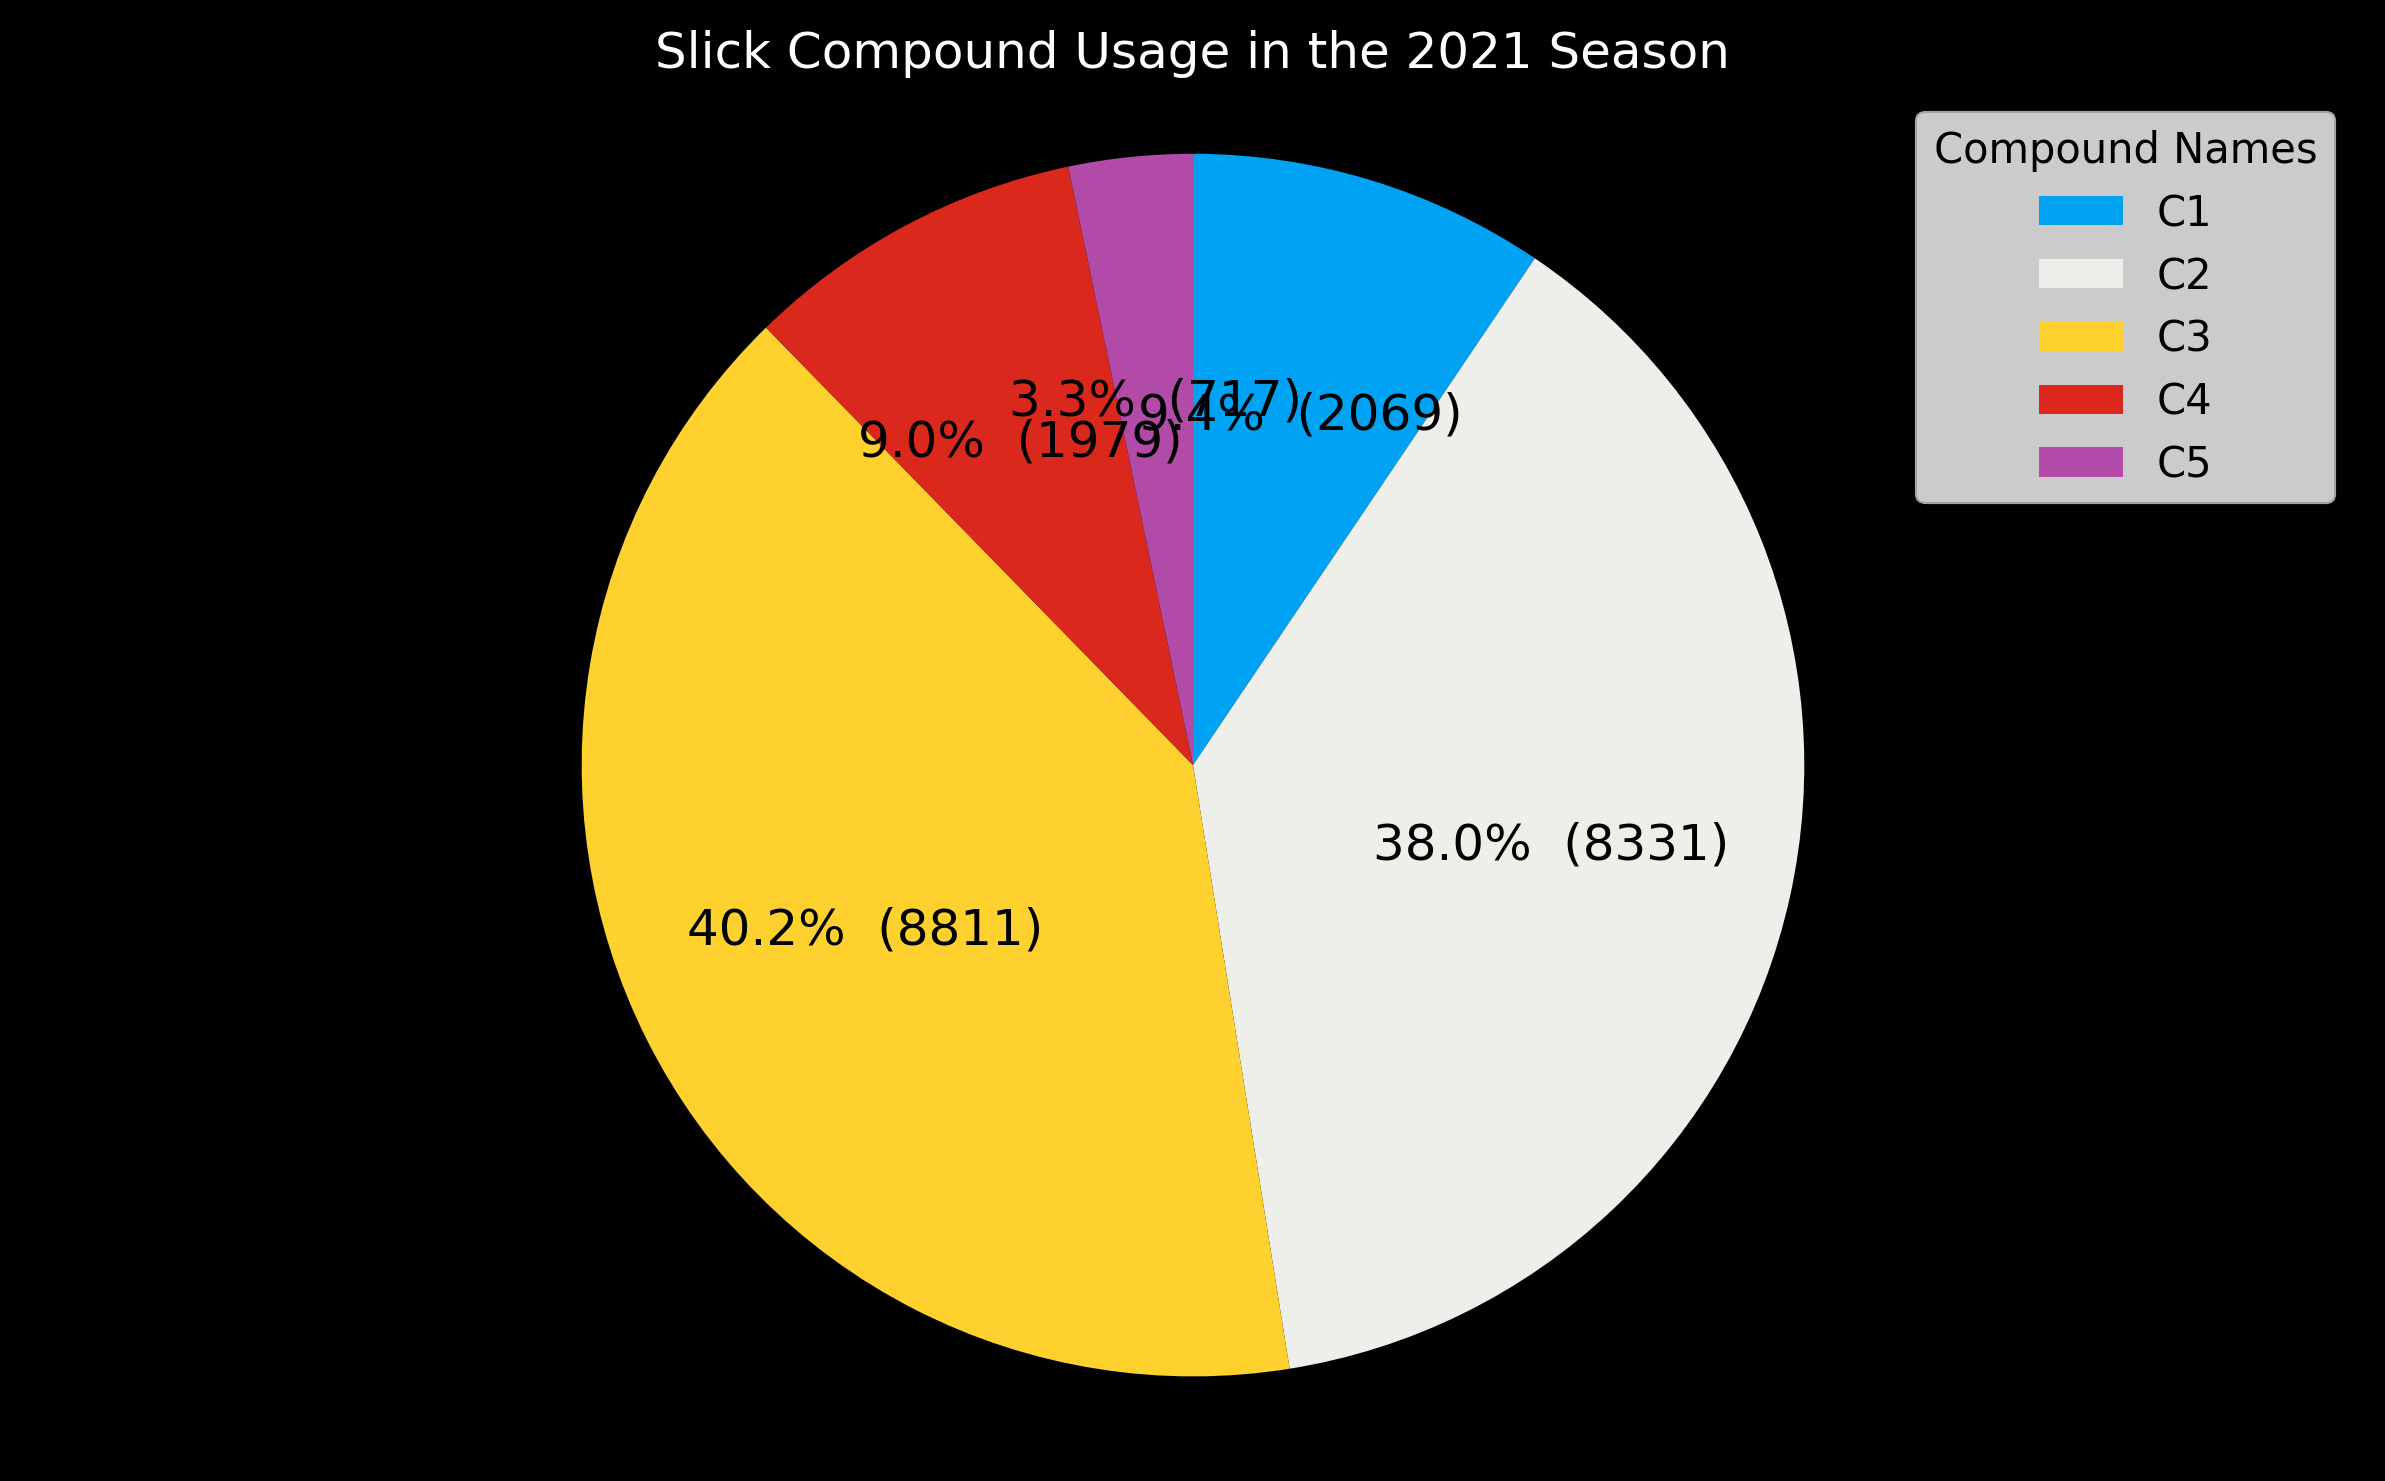

In [48]:
pie_chart = tyre_usage_pie(year=2021, 
                           title="Slick Compound Usage in the 2021 Season", 
                           events=None, 
                           drivers=None, 
                           slick_only=True, 
                           absolute_compound=True)

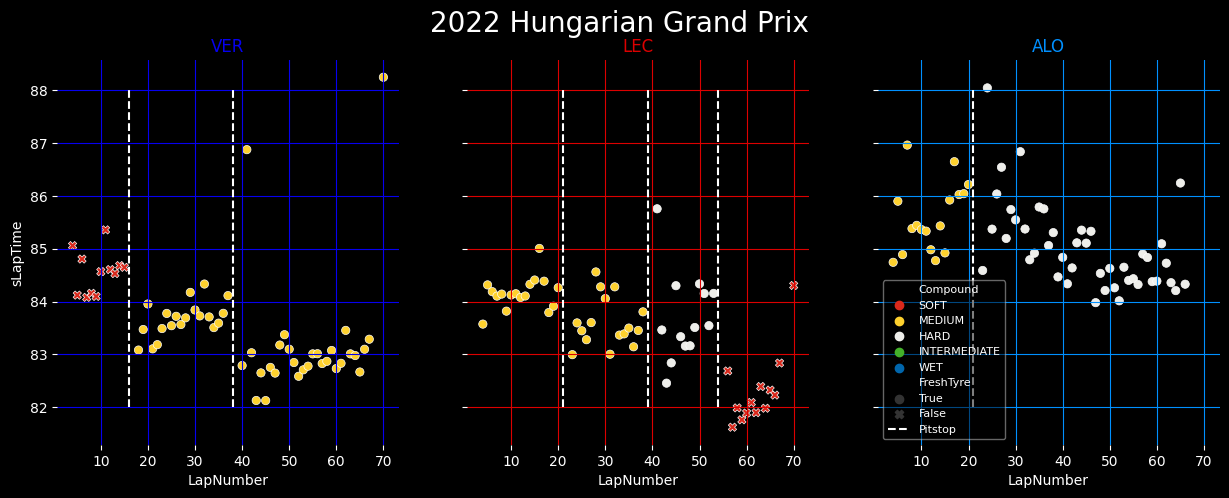

In [49]:
lap_time_lineplot = plot_driver_lap_times(year=2022, 
                                          event="Hungary", 
                                          drivers=["VER", "LEC", "ALO"], 
                                          y="sLapTime", 
                                          upper_bound=10, 
                                          absolute_compound=False)

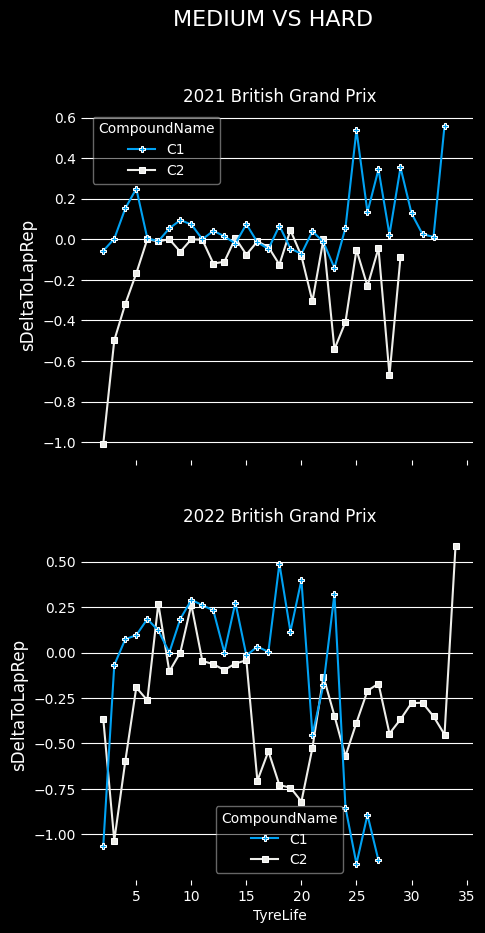

[]

In [50]:
tyre_lineplot, warnings = plot_compounds_lineplot(years=[2021, 2022], 
                                        events=["Silverstone", "Silverstone"], 
                                        y="sDeltaToLapRep", 
                                        compounds=["MEDIUM", "HARD"], 
                                        x="TyreLife", 
                                        upper_bound=10, 
                                        absolute_compound=True)
warnings

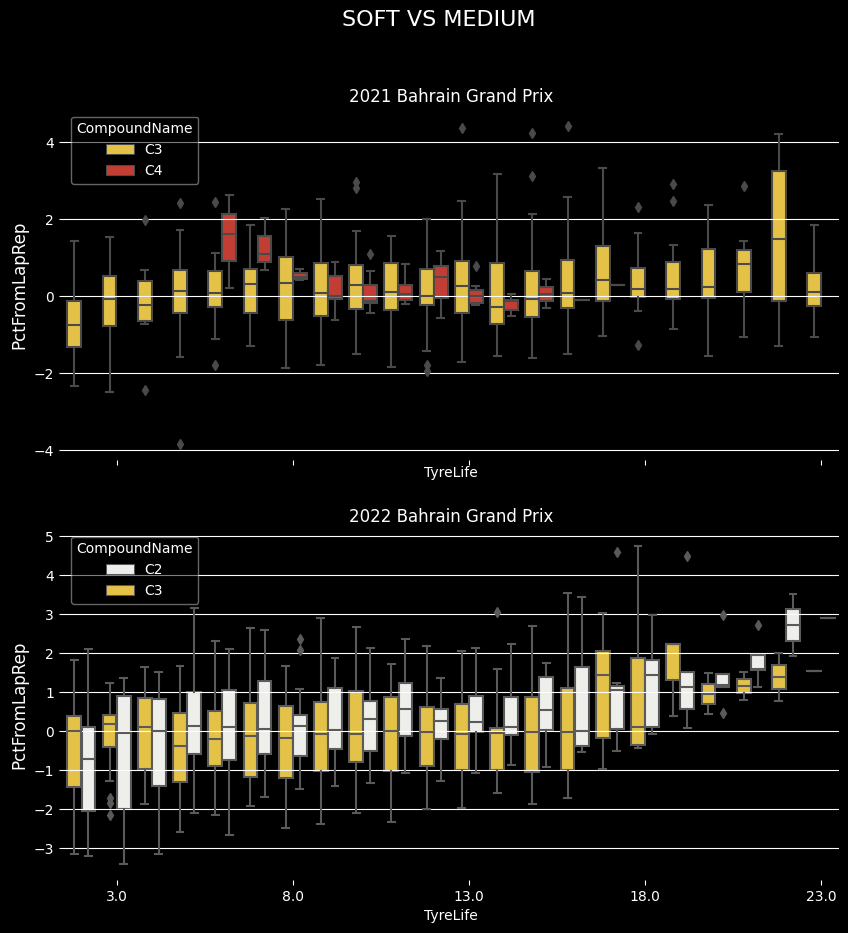

[]

In [51]:
tyre_boxplot, warnings = plot_compounds_boxplot(years=[2021, 2022], 
                                      events=["Bahrain", "Bahrain"], 
                                      y="PctFromLapRep", 
                                      compounds=["SOFT", "MEDIUM"],
                                      x="TyreLife", 
                                      upper_bound=10, 
                                      absolute_compound=True)
warnings

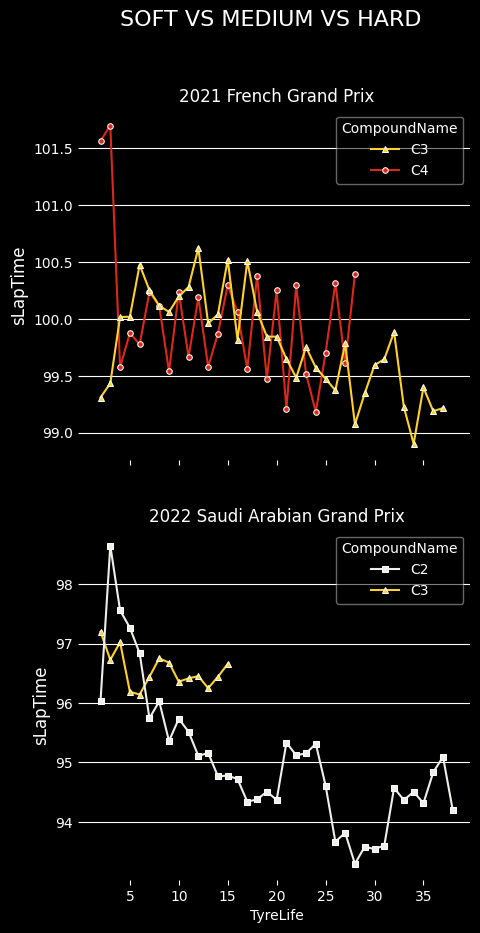

['C5 is not plotted for 2021 French Grand Prix because there is no valid lap time data',
 'C4 is not plotted for 2022 Saudi Arabian Grand Prix because there is no valid lap time data']

In [52]:
lineplot_with_warnings, warnings = plot_compounds_lineplot([2021, 2022], 
                                             ["French", "Saudi Arabia"], 
                                             y="sLapTime")
warnings

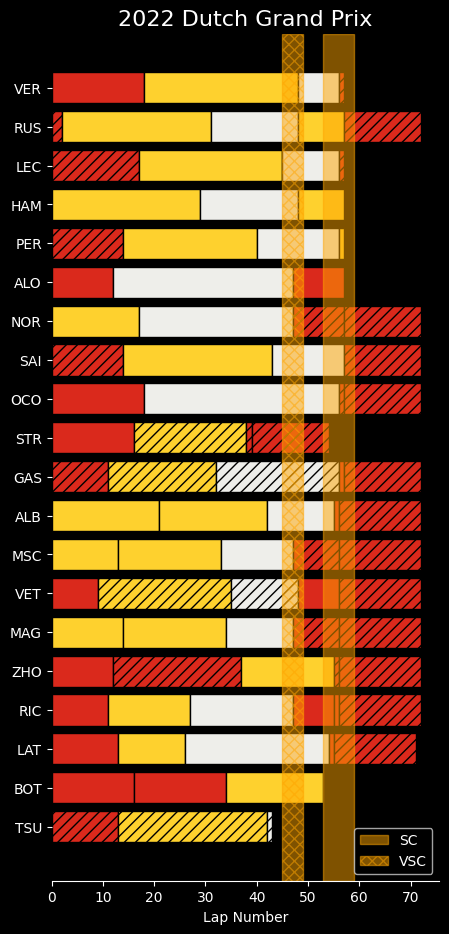

In [53]:
# some tyre compound data is missing from this grand prix
strategy_barplot = plot_strategies_barplot(2022, "Dutch", drivers=None)